<a href="https://colab.research.google.com/github/thareqky/MexicoTS/blob/main/EDA_and_Forecast_of_Mexico_Toy_Store_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparation

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
!pip install pmdarima
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importing profit 2017 dataset
profit_url = 'https://docs.google.com/spreadsheets/d/1uBzilYPZDm5qpEUPgu0vSMJ_hNoUONlB5mjoHDWMyy0/edit#gid=429987040'
df17_csv = profit_url.replace('/edit#gid=', '/export?format=csv&gid=')
df17 = pd.read_csv(df17_csv, parse_dates = ['Date'], infer_datetime_format=True)
df17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420845 entries, 0 to 420844
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Sale_ID           420845 non-null  int64         
 1   Date              420845 non-null  datetime64[ns]
 2   Store_ID          420845 non-null  int64         
 3   Product_ID        420845 non-null  int64         
 4   Units             420845 non-null  int64         
 5   Product_Name      420845 non-null  object        
 6   Product_Category  420845 non-null  object        
 7   Product_Cost      420845 non-null  float64       
 8   Product_Price     420845 non-null  float64       
 9   Store_Name        420845 non-null  object        
 10  Store_City        420845 non-null  object        
 11  Store_Location    420845 non-null  object        
 12  Store_Open_Date   420845 non-null  object        
 13  Stock_On_Hand     420845 non-null  int64         
 14  Prof

In [ ]:
# Main Dataset 2017
df17['Cost'] = df17['Units']*df17['Product_Cost']
df17['Revenue'] =  df17['Units']*df17['Product_Price']
df17

,Sale_ID,Date,Store_ID,Product_ID,Units,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,Store_City,Store_Location,Store_Open_Date,Stock_On_Hand,Profit,Cost,Revenue
0,1,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,1,3,9.99,12.99
1,2,2017-01-01,28,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Puebla 2,Puebla,Downtown,2011-04-01,6,6,9.99,15.99
2,3,2017-01-01,6,8,1,Deck Of Cards,Games,3.99,6.99,Maven Toys Mexicali 1,Mexicali,Commercial,2003-12-13,50,3,3.99,6.99
3,4,2017-01-01,48,7,1,Dart Gun,Sports & Outdoors,11.99,15.99,Maven Toys Saltillo 2,Saltillo,Commercial,2016-03-23,28,4,11.99,15.99
4,5,2017-01-01,44,18,1,Lego Bricks,Toys,34.99,39.99,Maven Toys Puebla 3,Puebla,Residential,2014-12-27,117,5,34.99,39.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420840,420841,2017-12-31,3,18,1,Lego Bricks,Toys,34.99,39.99,Maven Toys Guadalajara 2,Guadalajara,Commercial,1999-12-27,52,5,34.99,39.99
420841,420842,2017-12-31,21,8,3,Deck Of Cards,Games,3.99,6.99,Maven Toys Santiago 1,Santiago,Downtown,2009-11-23,11,9,11.97,20.97
420842,420843,2017-12-31,50,30,1,Rubik's Cube,Games,17.99,19.99,Maven Toys Guanajuato 3,Guanajuato,Residential,2016-05-18,4,2,17.99,19.99
420843,420844,2017-12-31,25,27,1,PlayDoh Toolkit,Art & Crafts,3.99,4.99,Maven Toys Ciudad Victoria 1,Ciudad Victoria,Downtown,2010-09-08,29,1,3.99,4.99


# Timely Analysis

In [ ]:
daily = df17.groupby('Date').sum()
daily = daily.drop(columns=['Sale_ID','Store_ID','Product_ID'])
daily['Profit_Margin'] = (daily['Profit']/daily['Revenue'])*100
daily.reset_index(drop=False, inplace=True)
daily

,Date,Units,Product_Cost,Product_Price,Stock_On_Hand,Profit,Cost,Revenue,Profit_Margin
0,2017-01-01,1485,11496.36,16015.36,32072,6058,15018.15,21076.15,28.743390
1,2017-01-02,1406,9780.89,14248.89,23610,6785,12965.94,19750.94,34.352795
2,2017-01-03,750,7169.97,9676.97,16893,3383,8376.50,11759.50,28.768230
3,2017-01-04,960,7417.51,11170.51,20726,5290,9524.40,14814.40,35.708500
4,2017-01-05,1370,10740.54,15163.54,24390,6012,13779.30,19791.30,30.376984
...,...,...,...,...,...,...,...,...,...
360,2017-12-27,1599,10551.35,14932.35,31624,5902,14879.01,20781.01,28.400930
361,2017-12-28,1465,10895.25,14561.25,27950,4709,14386.35,19095.35,24.660454
362,2017-12-29,2114,16413.76,22630.76,45603,7966,20047.86,28013.86,28.435924
363,2017-12-30,2288,17300.57,24504.57,50755,9079,21778.12,30857.12,29.422707


In [ ]:
# del daily

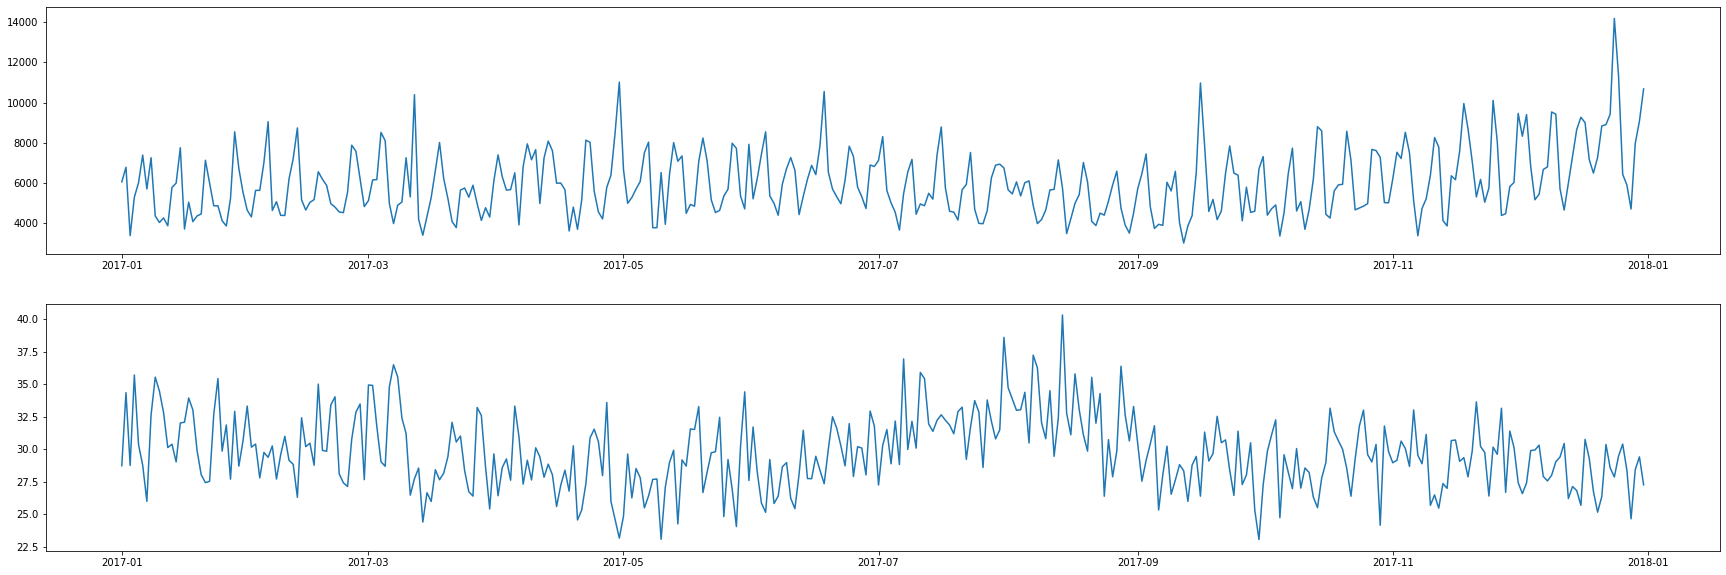

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.plot('Date','Profit',data=daily)
plt.subplot(212)
plt.plot('Date','Profit_Margin',data=daily)
# show the graph
plt.show()

In [ ]:
monthly = daily.copy()
monthly['Month'] = monthly['Date'].dt.strftime('%m')
monthly = monthly.groupby('Month').sum().reset_index()
monthly['Profit_Margin'] = (monthly['Profit']/monthly['Revenue'])*100
monthly

,Month,Units,Product_Cost,Product_Price,Stock_On_Hand,Profit,Cost,Revenue,Profit_Margin
0,01,38009,300753.53,424575.53,736204,167126,375428.91,542554.91,30.803518
1,02,36935,301576.49,423687.49,715859,161861,379490.65,541351.65,29.899419
2,03,39981,331706.24,464698.24,762338,173992,415493.19,589485.19,29.515924
3,04,47102,370903.84,512119.84,906415,190099,490973.98,681072.98,27.911693
4,05,46910,386121.36,533924.36,876748,186894,485475.90,672369.90,27.796307
5,06,47178,360494.85,507381.85,865504,189815,472165.22,661980.22,28.673817
6,07,46177,297479.85,436729.85,851009,176922,379112.23,556034.23,31.818545
7,08,39927,271566.96,397353.96,760399,158931,330491.73,489422.73,32.473155
8,09,42196,347819.33,481076.33,807729,166397,419447.04,585844.04,28.402952
9,10,47861,359482.49,500332.49,929790,178799,445075.39,623874.39,28.659455


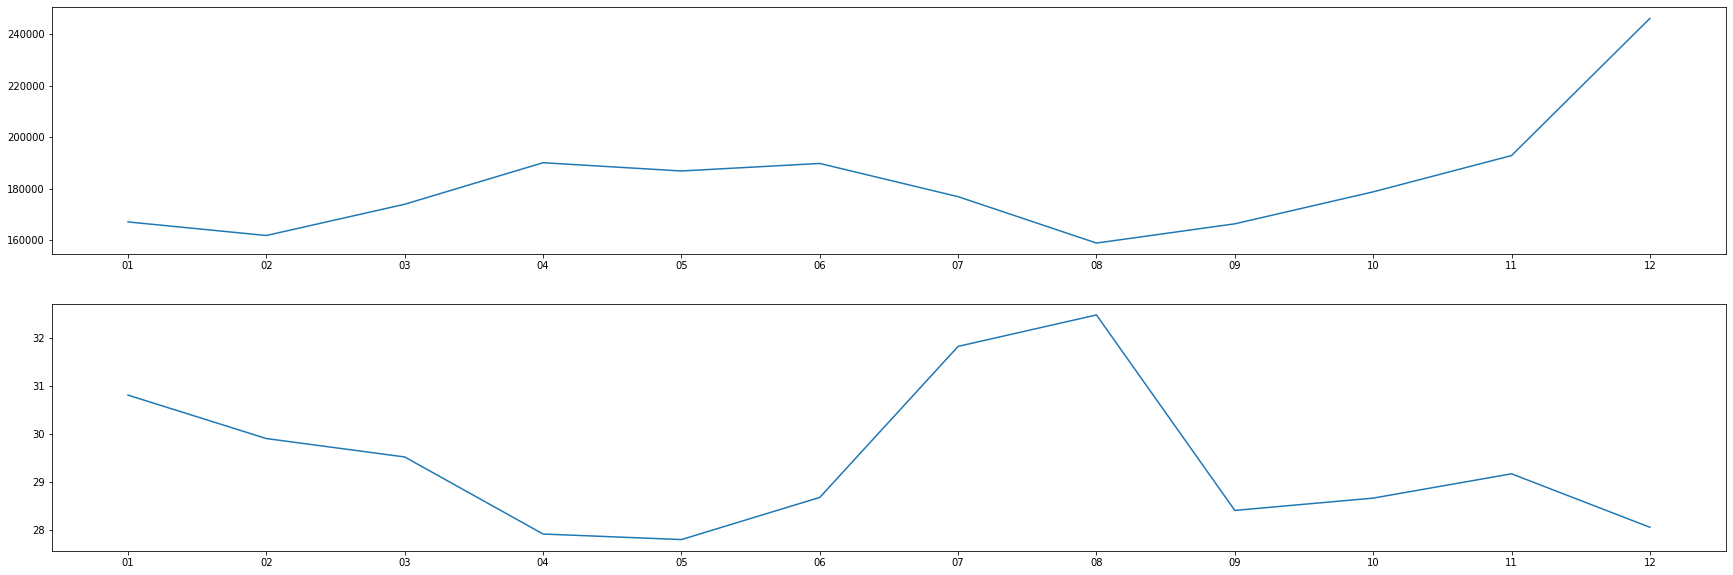

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.plot('Month','Profit',data=monthly)
plt.subplot(212)
plt.plot('Month','Profit_Margin',data=monthly)

# show the graph
plt.show()

In [ ]:
weekday = daily.copy()
cats = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekday['Weekday'] = pd.Categorical(weekday['Date'].dt.strftime('%A'), categories=cats, ordered=True)
weekday = weekday.sort_values('Date')
weekdaygroup = weekday.groupby('Weekday').sum().reset_index()
fig = px.bar(weekdaygroup, x="Weekday", y="Profit", title="Weekday Sales")
fig.show()

# Store Analysis

In [ ]:
df17.groupby(['Store_City','Store_Location']).sum().to_csv('/content/Location_Sum.csv')

In [ ]:
df17.groupby(['Store_Name']).sum().to_csv('/content/Store_Sum.csv')

In [ ]:
fig = px.bar(df17.groupby(['Store_City','Store_Location']).sum().reset_index(), x="Store_City", y="Profit", color="Store_Location", title="Profit per City")
fig.show()

In [ ]:
location_desc = df17.copy()
# drop(columns=['Sale_ID','Date','Store_ID','Product_ID','Product_Cost','Product_Price'])
location_desc['Profit_Margin'] = (location_desc['Profit']/location_desc['Revenue'])*100
location_desc = location_desc.groupby('Store_Location').agg(
    {'Store_ID' : 'nunique',
     'Units' : 'sum', 
     'Stock_On_Hand' : 'sum',
     'Cost' : 'sum',
     'Revenue' : 'sum',
     'Profit' : 'sum',
     'Profit_Margin' : 'mean'}).rename({'Store_ID': 'Store_Count'}, axis=1)
location_desc = location_desc.assign(
    Avg_Profit = location_desc['Profit']/location_desc['Store_Count'],
    Avg_Revenue = location_desc['Revenue']/location_desc['Store_Count'])
location_desc

,Store_Count,Units,Stock_On_Hand,Cost,Revenue,Profit,Profit_Margin,Avg_Profit,Avg_Revenue
Store_Location,,,,,,,,,
Airport,3,48350,955301,445245.50,650255.50,205010,32.963876,68336.666667,216751.833333
Commercial,12,125029,2248559,1208968.71,1726867.71,517899,32.667073,43158.250000,143905.642500
Downtown,29,313097,5867391,3009271.03,4227179.03,1217908,31.814262,41996.827586,145764.794138
Residential,6,63016,1370713,629225.84,878195.84,248970,31.368457,41495.000000,146365.973333


In [ ]:
# Answering Proucts Question 1B
fig = px.bar(df17.groupby(['Store_City','Product_Category']).sum().reset_index(), x="Store_City", y="Profit", color="Product_Category", title="Profit each Category")
fig.show()

In [ ]:
# Answering Proucts Question 1B
city_desc = df17.copy()
city_desc = city_desc.groupby(['Store_City','Product_Category'])[['Revenue','Units','Profit']].sum()
city_desc['Profit_Margin'] = (city_desc['Profit']/city_desc['Revenue'])*100
city_desc = city_desc.unstack(level=-1).drop(columns=['Revenue','Profit']).sort_values([('Units','Toys')],ascending=False)
city_desc.swaplevel(axis=1).sort_index(level=1, axis='columns',ascending=False).sort_index(level=0, axis='columns',ascending=False)

Product_Category   Toys               Sports & Outdoors                Games  \
                  Units Profit_Margin             Units Profit_Margin  Units   
Store_City                                                                     
Cuidad de Mexico  15630     22.187513             11001     22.268040  13977   
Guadalajara       14999     22.955506              6811     22.345429   8417   
Monterrey         12281     20.622821              9000     19.897271   7907   
Guanajuato         9468     20.504902              5148     23.459208   6425   
Puebla             8919     22.526040              3382     20.985881   5379   
Hermosillo         7866     21.505514              3919     21.036452   6238   
Toluca             6347     21.910761              4330     19.913233   4475   
Xalapa             6020     22.980797              3249     20.456533   3738   
Mexicali           5168     22.189776              3264     22.853544   4386   
Saltillo           4806     19.327028              4282     23.737947   5005   
Campeche           4351     26.258094              4870     28.426031   5003   
Chihuahua          4239     22.386211              5557     29.619612   4547   
Santiago           2936     21.391577              1229     21.007322   1893   
Cuernavaca         2765     21.665494              1223     22.017790   1365   
Aguascalientes     2745     20.639992              1569     25.198143   2359   
Chetumal           2721     19.986348              2042     21.869011   1936   
Oaxaca             2704     19.742360               981     19.827350   1757   
Chilpancingo       2685     22.319538              1161     22.486400   1794   
Ciudad Victoria    2505     21.321593               771     23.718972   1623   
Morelia            2440     21.709878              1482     20.307042   4613   
Pachuca            2370     23.843129              1857     24.397274   1605   
Villahermosa       2363     23.989350              1631     25.811891   2090   
San Luis Potosi    2356     18.756205              1443     21.518727   1667   
Tuxtla Gutierrez   2344     30.007987              1813     24.406599   1893   
Zacatecas          2342     21.220827              1117     21.636390   1335   
Merida             2290     22.096567              1459     23.419793   1943   
Durango            2058     22.072248              1244     18.752180   1677   
La Paz             1980     21.080614               990     25.643501   2002   
Culiacan           1647     19.960799              1888     21.405691   1392   

Product_Category               Electronics               Art & Crafts  \
                 Profit_Margin       Units Profit_Margin        Units   
Store_City                                                              
Cuidad de Mexico     32.934225        9599     46.545688        13014   
Guadalajara          26.727539        8994     45.635388        11051   
Monterrey            32.861306        7867     47.888191         9564   
Guanajuato           31.230673        4437     48.013365         6878   
Puebla               30.940509        4808     47.591507         8254   
Hermosillo           30.145926        8129     48.621391         7506   
Toluca               32.214205        2179     42.999544         6752   
Xalapa               31.763125        4242     44.979098         4973   
Mexicali             29.990310        5765     47.800776         4244   
Saltillo             31.160739        3881     46.673898         4639   
Campeche             30.569499        2445     43.535894         4575   
Chihuahua            29.276966        2795     46.849823         4200   
Santiago             29.879101        1501     44.139472         2618   
Cuernavaca           30.124809         613     43.052382         2186   
Aguascalientes       29.055068        1810     46.201111         1368   
Chetumal             30.550683        1343     51.634685         1736   
Oaxaca               29.029040         754     37.63

# Product Analysis

In [ ]:
fig = px.bar(df17.groupby(['Product_Category']).sum().reset_index(), x="Product_Category", y="Profit", title="Profit each Category")
fig.show()

In [ ]:
df17.head()

,Sale_ID,Date,Store_ID,Product_ID,Units,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,Store_City,Store_Location,Store_Open_Date,Stock_On_Hand,Profit,Cost,Revenue
0,1,2017-01-01,24,4,1,Chutes & Ladders,Games,9.99,12.99,Maven Toys Aguascalientes 1,Aguascalientes,Downtown,2010-07-31,1,3,9.99,12.99
1,2,2017-01-01,28,1,1,Action Figure,Toys,9.99,15.99,Maven Toys Puebla 2,Puebla,Downtown,2011-04-01,6,6,9.99,15.99
2,3,2017-01-01,6,8,1,Deck Of Cards,Games,3.99,6.99,Maven Toys Mexicali 1,Mexicali,Commercial,2003-12-13,50,3,3.99,6.99
3,4,2017-01-01,48,7,1,Dart Gun,Sports & Outdoors,11.99,15.99,Maven Toys Saltillo 2,Saltillo,Commercial,2016-03-23,28,4,11.99,15.99
4,5,2017-01-01,44,18,1,Lego Bricks,Toys,34.99,39.99,Maven Toys Puebla 3,Puebla,Residential,2014-12-27,117,5,34.99,39.99


In [ ]:
# Answering Products Question 1A and 1C
product_desc = df17.copy()
product_desc = product_desc.groupby(['Product_Category','Product_Name']).agg(
    {'Units' : 'sum',
     'Sale_ID' : 'nunique',
     'Revenue' : 'sum',
     'Cost' : 'sum',
     'Profit' : 'sum'}).rename({'Sale_ID': 'Transaction_Count'}, axis=1)
product_desc['Avg_Quantity'] = product_desc['Units']/product_desc['Transaction_Count']
product_desc['Avg_Cost'] = product_desc['Cost']/product_desc['Transaction_Count']
product_desc['Avg_Profit'] = product_desc['Profit']/product_desc['Transaction_Count']
product_desc['Profit_Margin'] = (product_desc['Profit']/product_desc['Revenue'])*100
product_desc
# .sort_values(by='Profit',ascending=False)

Units  Transaction_Count     Revenue  \
Product_Category  Product_Name                                                  
Art & Crafts      Barrel O' Slime        30431              17014   121419.69   
                  Etch A Sketch           2541               2326    53335.59   
                  Kids Makeup Kit        15996              14296   319760.04   
                  Magic Sand              6261               4425   100113.39   
                  PlayDoh Can            48185              31839   144073.15   
                  PlayDoh Playset         3632               3461    90763.68   
                  PlayDoh Toolkit        15466              13593    77175.34   
Electronics       Colorbuds              75212              50580  1127427.88   
                  Gamer Headphones        6366               5300   133622.34   
                  Toy Robot               6903               6172   179408.97   
Games             Chutes & Ladders        1932               1898    25096.68   
                  Classic Dominoes        2520               2398    25174.80   
                  Deck Of Cards          47550              38673   332374.50   
                  Glass Marbles          20872              14145   229383.28   
                  Jenga                   8009               7188    80009.91   
                  Monopoly                1744               1373    34862.56   
                  Rubik's Cube           24624              20602   492233.76   
                  Uno Card Game           1190               1123     9508.10   
Sports & Outdoors Dart Gun               21340              17534   341226.60   
                  Mini Basketball Hoop    1737               1696    43407.63   
                  Mini Ping Pong Set     14893               9867   148781.07   
                  Nerf Gun                9523               8632   190364.77   
                  Splash Balls           37040              25146   332989.60   
                  Supersoaker Water Gun   4180               3698    62658.20   
Toys              Action Figure          37035              31316   592189.65   
                  Animal Figures         22280              18295   289417.20   
                  Dino Egg               11125               8593   122263.75   
                  Dinosaur Figures       16984              14258   254590.16   
                  Hot Wheels 5-Pack      12077              11172    72341.23   
                  Lego Bricks            33291              26152  1331307.09   
                  Mr. Potatohead          2195               1901    21928.05   
                  Plush Pony              2957               2912    59110.43   
                  Teddy Bear              3401               3267    44178.99   

                                               Cost  Profit  Avg_Quantity  \
Product_Category  Product_Name                                              
Art & Crafts      Barrel O' Slime          60557.69   60862      1.788586   
                  Etch A Sketch            27925.59   25410      1.092433   
                  Kids Makeup Kit         223784.04   95976      1.118914   
                  Magic Sand               87591.39   12522      1.414915   
                  PlayDoh Can              95888.15   48185      1.513396   
                  PlayDoh Playset          76235.68   14528      1.049408   
                  PlayDoh Toolkit          61709.34   15466      1.137792   
Electronics       Colorbuds               525731.88  601696      1.486991   
                  Gamer Headphones         95426.34   38196      1.201132   
                  Toy Robot               144893.97   34515      1.118438   
Games             Chutes & Ladders         19300.68    5796      1.017914   
                  Classic Dominoes         20134.80    5040      1.050876   
                  Deck Of Cards           189724.50  142650      1.229540   
                  Glass Marbles           125023.2

In [ ]:
category_desc = df17.copy()
category_desc = category_desc.groupby(df17['Product_Category']).agg(
    {'Units' : 'sum',
     'Sale_ID' : 'nunique',
     'Revenue' : 'sum',
     'Cost' : 'sum',
     'Profit' : 'sum'}).rename({'Sale_ID': 'Transaction_Count'}, axis=1)
category_desc['Avg_Quantity'] = category_desc['Units']/category_desc['Transaction_Count']
category_desc['Profit_Margin'] = (category_desc['Profit']/category_desc['Revenue'])*100
category_desc.sort_values(by='Profit_Margin',ascending=False).reset_index()

,Product_Category,Units,Transaction_Count,Revenue,Cost,Profit,Avg_Quantity,Profit_Margin
0,Electronics,88481,62052,1440459.19,766052.19,674407,1.425917,46.818890
1,Games,108441,87400,1228643.59,850262.59,378381,1.240744,30.796645
2,Art & Crafts,122512,86954,906640.88,633691.88,272949,1.408929,30.105525
3,Sports & Outdoors,88713,66573,1119427.87,864401.87,255026,1.332567,22.781816
4,Toys,141345,117866,2787326.55,2178302.55,609024,1.199201,21.849754


In [ ]:
monthly_prod = df17.groupby(['Date','Product_Category']).sum().reset_index()
monthly_prod = monthly_prod.drop(columns=['Sale_ID','Store_ID','Product_ID'])
monthly_prod['Month'] = monthly_prod['Date'].dt.strftime('%m')
monthly_prod = monthly_prod.groupby(['Month','Product_Category']).sum().reset_index()
monthly_prod['Profit_Margin'] = (monthly_prod['Profit']/monthly_prod['Revenue'])*100
monthly_prod

,Month,Product_Category,Units,Product_Cost,Product_Price,Stock_On_Hand,Profit,Cost,Revenue,Profit_Margin
0,01,Art & Crafts,4282,21978.99,30610.99,103549,9928,25169.18,35097.18,28.287173
1,01,Electronics,8938,51119.15,95110.15,127020,69020,74068.62,143088.62,48.235842
2,01,Games,8802,55453.25,76930.25,272432,28308,69267.98,97575.98,29.011238
3,01,Sports & Outdoors,5312,44977.21,60451.21,86696,19409,55536.88,74945.88,25.897354
4,01,Toys,10675,127224.93,161472.93,146507,40461,151386.25,191847.25,21.090216
5,02,Art & Crafts,4727,21117.53,29627.53,110632,9740,24142.73,33882.73,28.746208
6,02,Electronics,8359,48887.16,92397.16,126578,64676,68677.41,133353.41,48.499697
7,02,Games,7898,51067.39,70314.39,224204,25764,64383.02,90147.02,28.579980
8,02,Sports & Outdoors,5451,46436.52,61341.52,89011,17945,55393.49,73338.49,24.468734
9,02,Toys,10500,134067.89,170006.89,165434,43736,166894.00,210630.00,20.764374


In [ ]:
fig = px.line(monthly_prod, x="Month", y="Profit", color='Product_Category')
fig.show()

In [ ]:
fig = px.line(monthly_prod, x="Month", y="Profit_Margin", color='Product_Category')
fig.show()

# Inventory Analysis

In [ ]:
inventory_url = 'https://docs.google.com/spreadsheets/d/18DuocQ-_OCiP4o-YqCe6ixFEcc8K-1zaxjl8Xq5Nufk/edit#gid=762360980'
inventory_csv = inventory_url.replace('/edit#gid=','/export?format=csv&gid=')
i = pd.read_csv(inventory_csv)
i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1593 entries, 0 to 1592
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Store_ID          1593 non-null   int64  
 1   Product_ID        1593 non-null   int64  
 2   Stock_On_Hand     1593 non-null   int64  
 3   Product_Name      1593 non-null   object 
 4   Product_Category  1593 non-null   object 
 5   Product_Cost      1593 non-null   float64
 6   Product_Price     1593 non-null   float64
 7   Store_Name        1593 non-null   object 
 8   Store_City        1593 non-null   object 
 9   Store_Location    1593 non-null   object 
 10  Store_Open_Date   1593 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 137.0+ KB


In [ ]:
i['Tied_Cost'] = i['Stock_On_Hand']*i['Product_Cost']
i['Tied_Revenue'] =  i['Stock_On_Hand']*i['Product_Price']
i['Tied_Profit'] = i['Tied_Revenue']-i['Tied_Cost']
i.head()

,Store_ID,Product_ID,Stock_On_Hand,Product_Name,Product_Category,Product_Cost,Product_Price,Store_Name,Store_City,Store_Location,Store_Open_Date,Tied_Cost,Tied_Revenue,Tied_Profit
0,1,1,27,Action Figure,Toys,9.99,15.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18,269.73,431.73,162.0
1,1,2,0,Animal Figures,Toys,9.99,12.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18,0.00,0.00,0.0
2,1,3,32,Barrel O' Slime,Art & Crafts,1.99,3.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18,63.68,127.68,64.0
3,1,4,6,Chutes & Ladders,Games,9.99,12.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18,59.94,77.94,18.0
4,1,5,0,Classic Dominoes,Games,7.99,9.99,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18,0.00,0.00,0.0


In [ ]:
# Answering 
iproduct = i.groupby(['Product_Category','Product_Name']).agg(
    {'Stock_On_Hand' : 'sum',
     'Tied_Cost' : 'sum',
     'Tied_Revenue' : 'sum',
     'Tied_Profit' : 'sum'})
iproduct

Stock_On_Hand  Tied_Cost  \
Product_Category  Product_Name                                      
Art & Crafts      Barrel O' Slime                 1282    2551.18   
                  Etch A Sketch                    402    4417.98   
                  Kids Makeup Kit                  606    8477.94   
                  Magic Sand                      1922   26888.78   
                  PlayDoh Can                     2129    4236.71   
                  PlayDoh Playset                  550   11544.50   
                  PlayDoh Toolkit                 1387    5534.13   
                  Playfoam                         357    1424.43   
Electronics       Colorbuds                       1159    8101.41   
                  Gamer Headphones                 637    9548.63   
                  Toy Robot                        622   13055.78   
Games             Chutes & Ladders                 255    2547.45   
                  Classic Dominoes                 241    1925.59   
                  Deck Of Cards                   2738   10924.62   
                  Glass Marbles                    795    4762.05   
                  Jenga                            181     541.19   
                  Monopoly                         207    2895.93   
                  Rubik's Cube                    1497   26931.03   
                  Uno Card Game                    241     961.59   
Sports & Outdoors Dart Gun                         776    9304.24   
                  Foam Disk Launcher               379    3407.21   
                  Mini Basketball Hoop             234    2103.66   
                  Mini Ping Pong Set               974    6808.26   
                  Nerf Gun                        1212   18167.88   
                  Splash Balls                     893    7135.07   
                  Supersoaker Water Gun            513    6150.87   
Toys              Action Figure                    614    6133.86   
                  Animal Figures                   835    8341.65   
                  Dino Egg                         649    6483.51   
                  Dinosaur Figures                2272   24969.28   
                  Hot Wheels 5-Pack                376    1500.24   
                  Lego Bricks                     1118   39118.82   
                  Mr. Potatohead                   709    3537.91   
                  Plush Pony                       497    4468.03   
                  Teddy Bear                       483    5308.17   

                                         Tied_Revenue  Tied_Profit  
Product_Category  Product_Name                                      
Art & Crafts      Barrel O' Slime             5115.18       2564.0  
                  Etch A Sketch               8437.98       4020.0  
                  Kids Makeup Kit            12113.94       3636.0  
                  Magic Sand                 30732.78       3844.0  
                  PlayDoh Can                 6365.71       2129.0  
                  PlayDoh Playset            13744.50       2200.0  
                  PlayDoh Toolkit             6921.13       1387.0  
                  Playfoam                    3923.43       2499.0  
Electronics       Colorbuds                  17373.41       9272.0  
                  Gamer Headphones           13370.63       3822.0  
                  Toy Robot                  16165.78       3110.0  
Games             Chutes & Ladders            3312.45        765.0  
                  Classic Dominoes            2407.59        482.0  
                  Deck Of Cards              19138.62       8214.0  
                  Glass Marbles               8737.05       3975.0  
                  Jenga                       1808.19       1267.0  
                  Monopoly                    4137.93       1242.0  
                  Rubik's Cube               29925.03       2994.0  
                  Uno Card Game               1925.59        964.0  
Sports & Outdoors Dart Gun            

# Forecasting

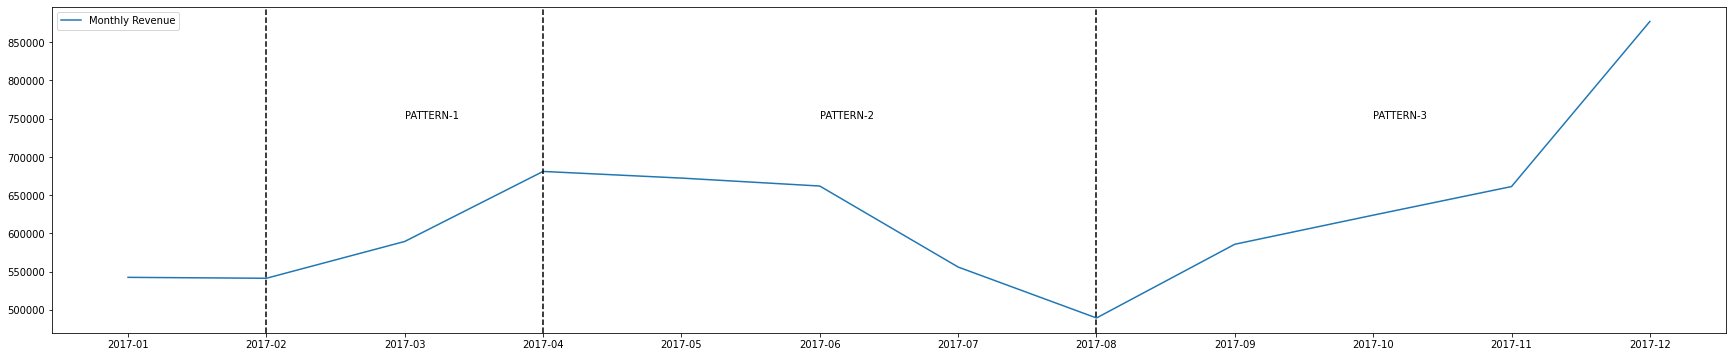

In [ ]:
# Possible Pattern
sales_monthly = df17.copy()
sales_monthly = df17.groupby([df17['Date'].dt.year.rename('year'), df17['Date'].dt.to_period("M").rename('month')])['Revenue'].sum().reset_index()
sales_monthly['month'] = sales_monthly['month'].astype(str)

plt.figure(figsize=(30, 6))
plt.plot(sales_monthly['month'],sales_monthly['Revenue'], label='Monthly Revenue')
plt.legend()

xkor = ['2017-04','2017-02', '2017-08']
for xc in xkor:
    plt.axvline(x=xc, color='black', linestyle='--')
    
    
plt.annotate('PATTERN-1', ('2017-03', 750000))
plt.annotate('PATTERN-2', ('2017-06', 750000))
plt.annotate('PATTERN-3', ('2017-10', 750000))


plt.show()

In [ ]:
weekly = df17.copy()
weekly = pd.DataFrame(weekly.groupby([weekly['Date'].dt.year.rename('year'), weekly['Date'].dt.to_period("W").rename('week')])['Revenue'].sum().reset_index().drop('year', axis=1).set_index('week'))
weekly.head()

,Revenue
week,
2016-12-26/2017-01-01,21076.15
2017-01-02/2017-01-08,135981.89
2017-01-09/2017-01-15,113695.84
2017-01-16/2017-01-22,117026.21
2017-01-23/2017-01-29,122800.86


In [ ]:
# weekly = weekly.drop(index='2016-12-26/2017-01-01')
# weekly.head()

In [ ]:
arima_model=auto_arima(weekly['Revenue'], start_p=1,d=1,start_q=1,
                      max_p=3,max_q=3,max_d=3,m=12,
                        start_P=0,D=1,start_Q=0,max_P=3,max_D=3,max_Q=3,
                      seasonal=True,
                       trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=951.170, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=936.600, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=923.342, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=910.024, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=941.515, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=911.996, Time=0.20 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=911.971, Time=0.32 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=923.165, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=910.266, Time=0.22 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=911.127, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=908.752, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=944.417, Time=0.04 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AI

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   53
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -451.376
Date:                              Sat, 03 Dec 2022   AIC                            908.752
Time:                                      07:22:21   BIC                            913.819
Sample:                                  01-01-2017   HQIC                           910.584
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3352      0.204     -1.643      0.100      -0.735       0.065
ma.S.L12      -0.8194      0.211     -3.884      0.000      -1.233      -0.406
sigma2      3.727e+08   6.89e-10   5.41e+17      0.000    3.73e+08    3.73e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                12.28
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.74
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+33. Standard errors may be unstable.
"""

In [ ]:
size=int(len(weekly)*0.70)
X_train,X_test=weekly[0:size],weekly[size:len(weekly)]

model=SARIMAX(weekly['Revenue'],
             order=(1,1,0),
             seasonal_order=(0,1,1,12))
result=model.fit()
result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              Revenue   No. Observations:                   53
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -451.376
Date:                              Sat, 03 Dec 2022   AIC                            908.752
Time:                                      07:22:22   BIC                            913.819
Sample:                                  01-01-2017   HQIC                           910.584
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3352      0.204     -1.643      0.100      -0.735       0.065
ma.S.L12      -0.8194      0.211     -3.884      0.000      -1.233      -0.406
sigma2      3.727e+08   6.89e-10   5.41e+17      0.000    3.73e+08    3.73e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                12.28
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.74
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+33. Standard errors may be unstable.
"""

Optimization terminated successfully.
         Current function value: 7.655352
         Iterations: 186
         Function evaluations: 367


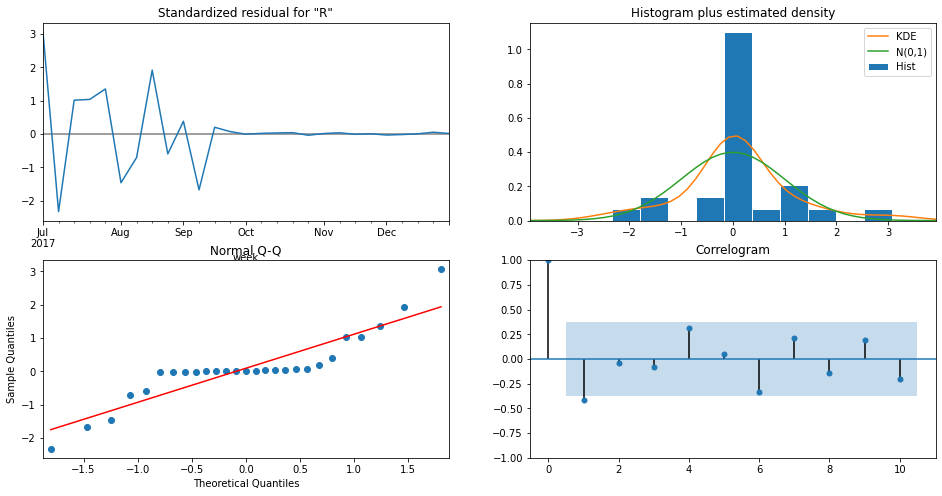

In [ ]:
mod = sm.tsa.statespace.SARIMAX(weekly,
                                order=(1, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(maxiter=200,method='nm')

results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
start_index=0
end_index=len(X_train)-1
train_prediction=result.predict(start_index,end_index)

st_index=len(X_train)
ed_index=len(weekly)-1
prediction=result.predict(st_index,ed_index)

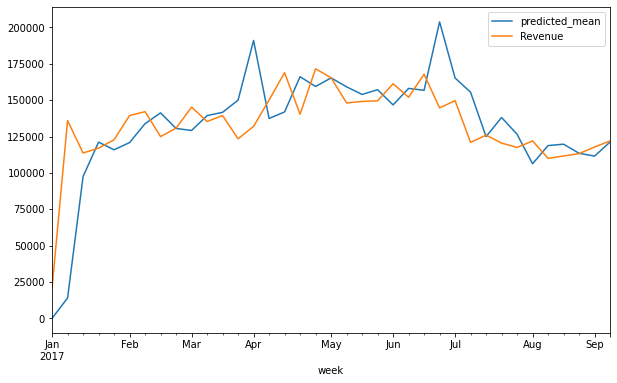

In [ ]:
plt.figure(figsize=(10, 6))
train_prediction.plot(legend=True)
X_train['Revenue'].plot(legend=True)

In [ ]:
print('Absolute Error:', metrics.mean_absolute_error(X_train, train_prediction))
print('MSE:', metrics.mean_squared_error(X_train, train_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_train, train_prediction)))

Absolute Error: 17062.85428240322
MSE: 779427451.7496098
RMSE: 27918.22794787681


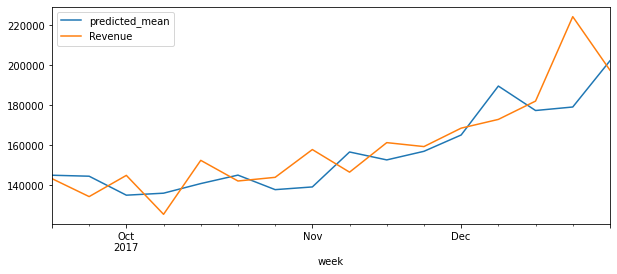

In [ ]:
plt.figure(figsize=(10, 4))
prediction.plot(legend=True)
X_test['Revenue'].plot(legend=True)

In [ ]:
print('Absolute Error:', metrics.mean_absolute_error(X_test, prediction))
print('MSE:', metrics.mean_squared_error(X_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test, prediction)))

Absolute Error: 10462.820767962454
MSE: 212455276.72895136
RMSE: 14575.845660851084


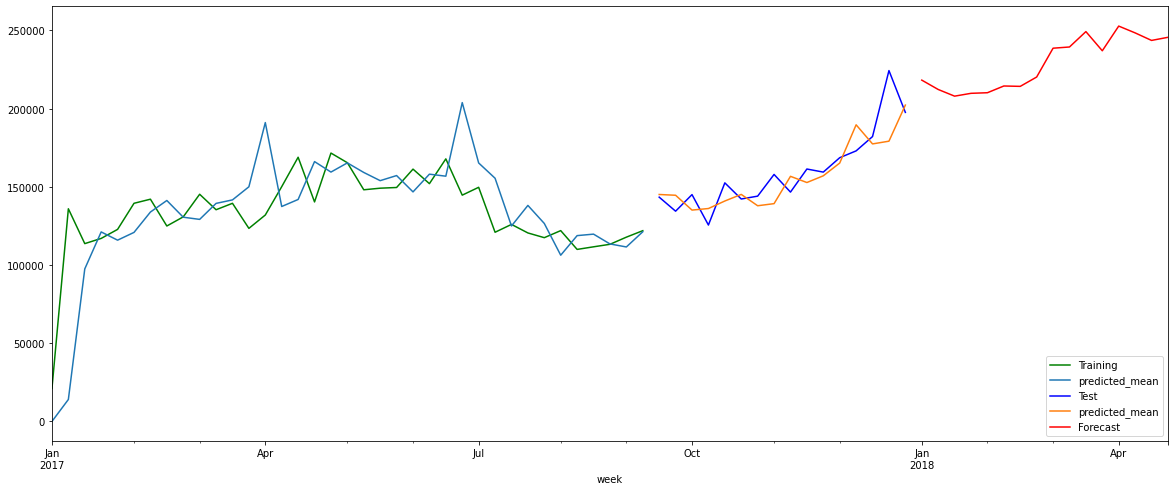

In [ ]:
forecast=result.predict(len(weekly), (len(weekly)-1)+16).rename('Forecast')

plt.figure(figsize=(20,8))

X_train['Revenue'].plot(label="Training",color='green')
train_prediction.plot(legend=True)
X_test['Revenue'].plot(label="Test",color='blue')
prediction.plot(legend=True)
forecast.plot(label="Forecast",color="red")
plt.legend(loc="lower right")

In [ ]:
dfforecast = forecast.to_frame()

In [ ]:
dfforecast.to_csv('/content/Forecast.csv')

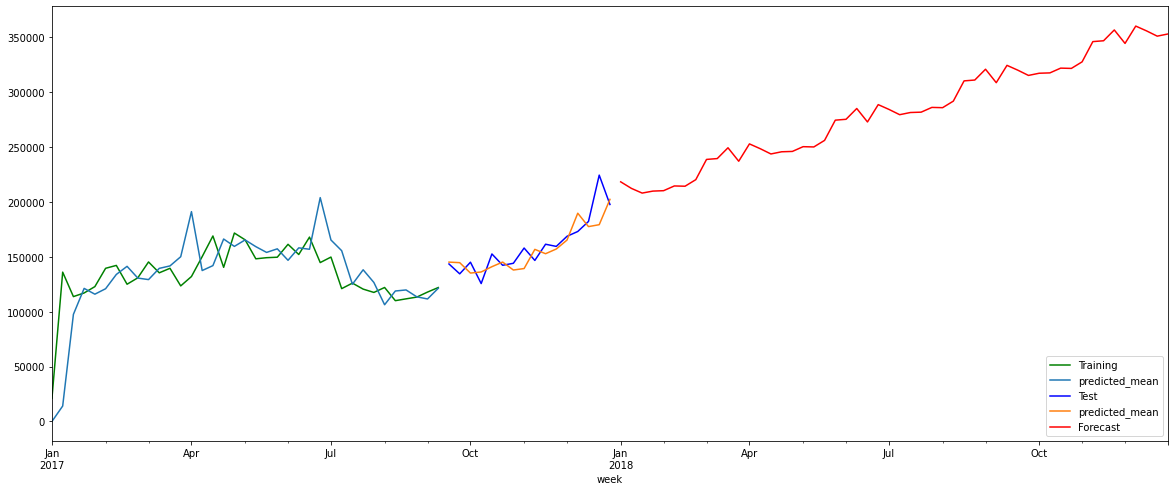

In [ ]:
forecast=result.predict(len(weekly), (len(weekly)-1)+52).rename('Forecast')

plt.figure(figsize=(20,8))

X_train['Revenue'].plot(label="Training",color='green')
train_prediction.plot(legend=True)
X_test['Revenue'].plot(label="Test",color='blue')
prediction.plot(legend=True)
forecast.plot(label="Forecast",color="red")
plt.legend(loc="lower right")

In [ ]:
dfforecast = forecast.to_frame()

In [ ]:
dfforecast.to_csv('/content/ForecastYear.csv')

In [ ]:
weekly.reset_index().drop(columns='week').to_csv('/content/Weekly.csv')